In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from MemSE.train_test_loop import test, test_mse_th, test_mse_sim
from MemSE.model_load import load_memristor, find_existing
from MemSE.dataset import get_dataloader, get_output_loader
from MemSE.nn import mse_gamma

device = torch.device('cpu')
print(device)

bs = 4
nb_batch = 100 / bs
train_loader, valid_loader, test_loader, nclasses, input_shape = get_dataloader('CIFAR10', bs=bs)

criterion = nn.CrossEntropyLoss().to(device)
batch = next(iter(test_loader))
batch_input = batch[0]

models_names = ['smallest_vgg', 'really_small_vgg']

N = 128

memse = load_memristor(models_names[0], nclasses, 'all', device, input_shape, 0.01, N, gmax=2.)
output_loader = get_output_loader(valid_loader, memse.model)
t = memse.model(batch_input)
memse.quant(c_one=True)

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
cpu
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Loading model checkpoint


In [3]:
print(memse.model)

VGG(
  (features): Sequential(
    (0): Sequential(
      (0): LambdaLayer()
      (1): Flatten(start_dim=1, end_dim=-1)
      (2): Linear(in_features=3468, out_features=2048, bias=False)
      (3): LambdaLayer()
    )
    (1): Softplus(beta=1, threshold=20)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Sequential(
      (0): LambdaLayer()
      (1): Flatten(start_dim=1, end_dim=-1)
      (2): Linear(in_features=648, out_features=1024, bias=False)
      (3): LambdaLayer()
    )
    (4): Softplus(beta=1, threshold=20)
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Sequential(
      (0): LambdaLayer()
      (1): Flatten(start_dim=1, end_dim=-1)
      (2): Linear(in_features=400, out_features=512, bias=False)
      (3): LambdaLayer()
    )
    (7): Softplus(beta=1, threshold=20)
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (9): Sequential(
      (0): LambdaLayer()
      (1): Flatten(start_dim=1, end_dim=-1)
      (2): Linear(in_features=288

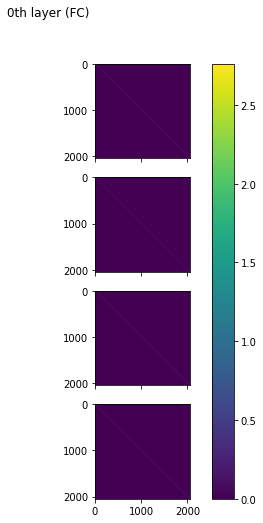

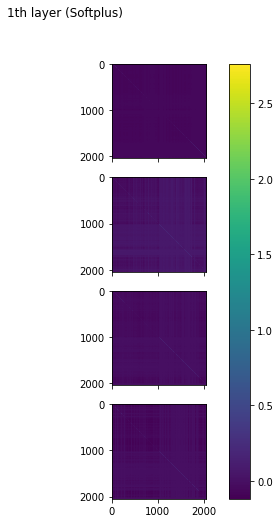

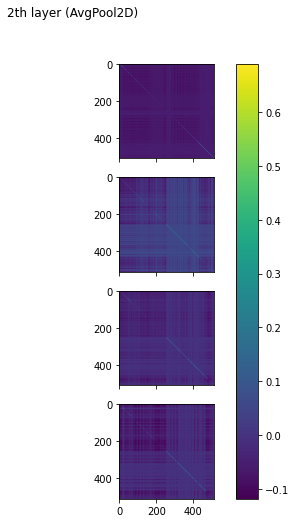

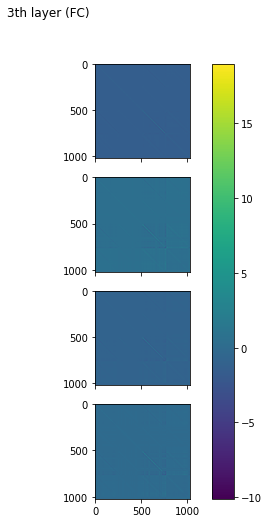

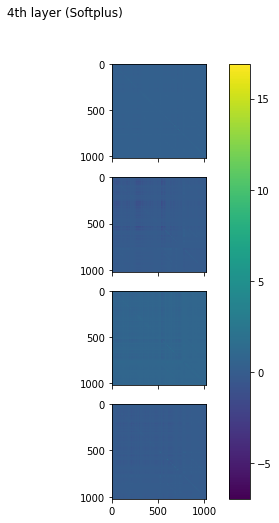

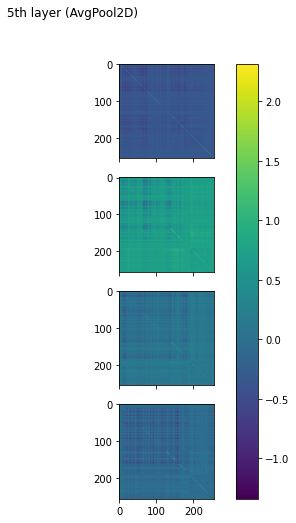

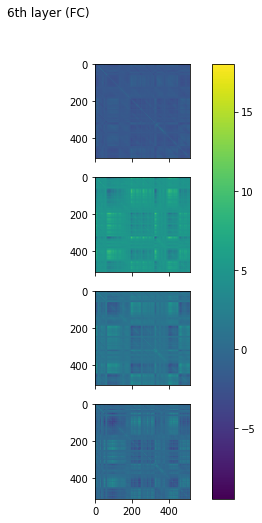

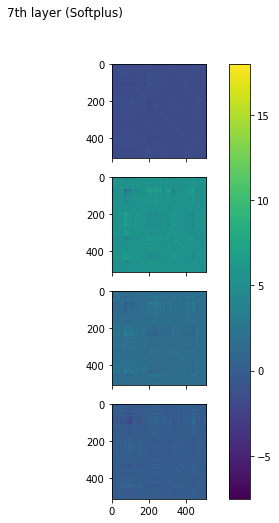

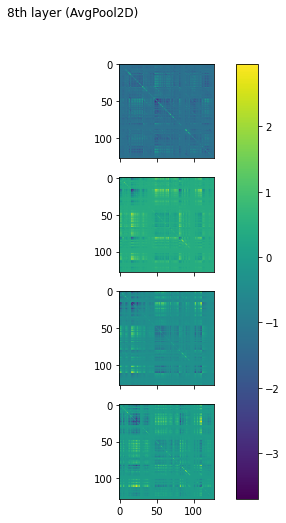

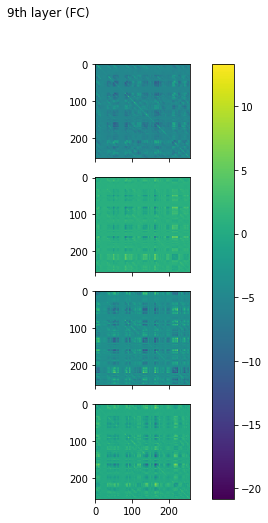

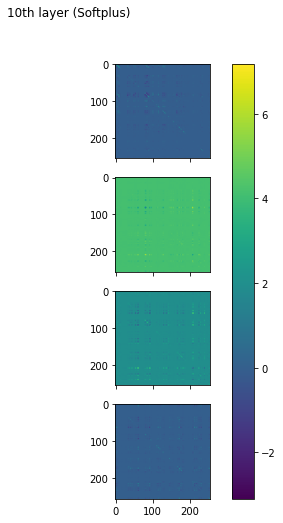

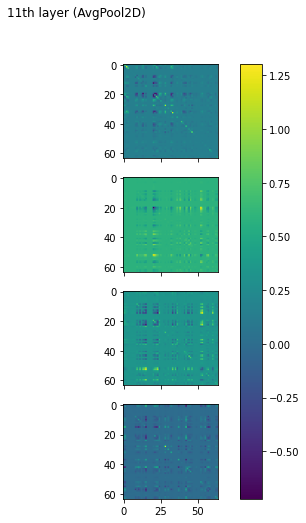

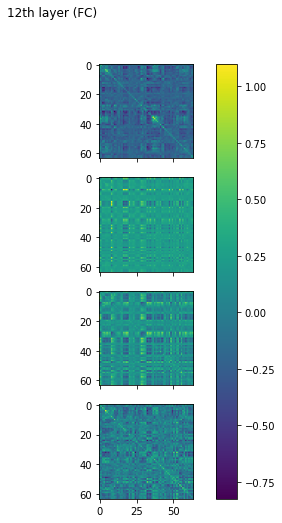

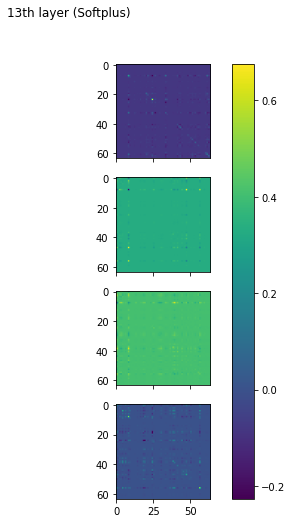

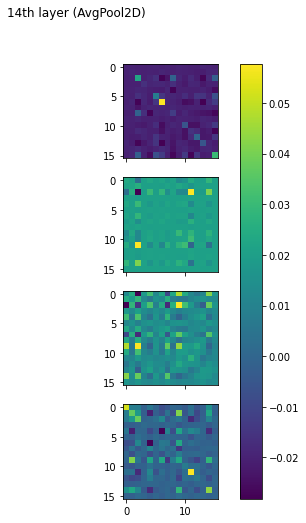

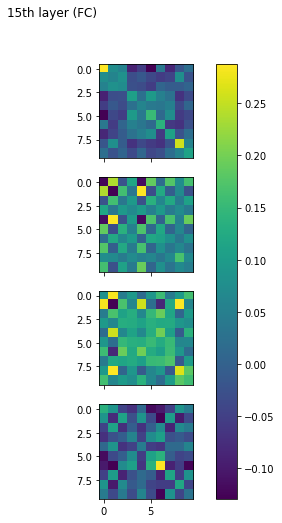

tensor([347669.7500, 816399.9375, 504183.4375, 626913.5000],
       grad_fn=<AddBackward0>)
tensor([ 0.7550, 10.0697,  3.1604,  1.9490], grad_fn=<MeanBackward1>)


In [2]:
x, g, p = memse.forward(batch_input, True, 'imshow')
plt.show()
print(p)
print(mse_gamma(t,x,g).mean(dim=1))

In [2]:
mses, varis = [], {}
for idx, (inp, tar) in enumerate(output_loader):
    inp, tar = inp.to(device), tar.to(device)
    x, g, p = memse.forward(inp, True)
    mse = mse_gamma(tar,x,g,verbose=True).mean(dim=1)
    mses.extend(mse.cpu().tolist())
    for k, v in memse._var_batch.items():
        if not k in varis:
            varis[k] = []
        varis[k].extend(v)
    if idx > nb_batch:
        break

VAR IMPORTANCE tensor([0.0125, 0.0886, 0.0142, 0.0462], grad_fn=<DivBackward0>)
EXP IMPORTANCE tensor([0.9875, 0.9114, 0.9858, 0.9538], grad_fn=<DivBackward0>)
VAR IMPORTANCE tensor([0.0233, 0.0687, 0.0758, 0.0097], grad_fn=<DivBackward0>)
EXP IMPORTANCE tensor([0.9767, 0.9313, 0.9242, 0.9903], grad_fn=<DivBackward0>)
VAR IMPORTANCE tensor([0.0178, 0.1913, 0.1282, 0.0481], grad_fn=<DivBackward0>)
EXP IMPORTANCE tensor([0.9822, 0.8087, 0.8718, 0.9519], grad_fn=<DivBackward0>)
VAR IMPORTANCE tensor([0.0716, 0.0670, 0.0723, 0.1151], grad_fn=<DivBackward0>)
EXP IMPORTANCE tensor([0.9284, 0.9330, 0.9277, 0.8849], grad_fn=<DivBackward0>)
VAR IMPORTANCE tensor([0.0549, 0.0425, 0.0144, 0.1417], grad_fn=<DivBackward0>)
EXP IMPORTANCE tensor([0.9451, 0.9575, 0.9856, 0.8583], grad_fn=<DivBackward0>)
VAR IMPORTANCE tensor([0.0436, 0.1113, 0.0255, 0.0152], grad_fn=<DivBackward0>)
EXP IMPORTANCE tensor([0.9564, 0.8887, 0.9745, 0.9848], grad_fn=<DivBackward0>)
VAR IMPORTANCE tensor([0.1262, 0.0210, 0

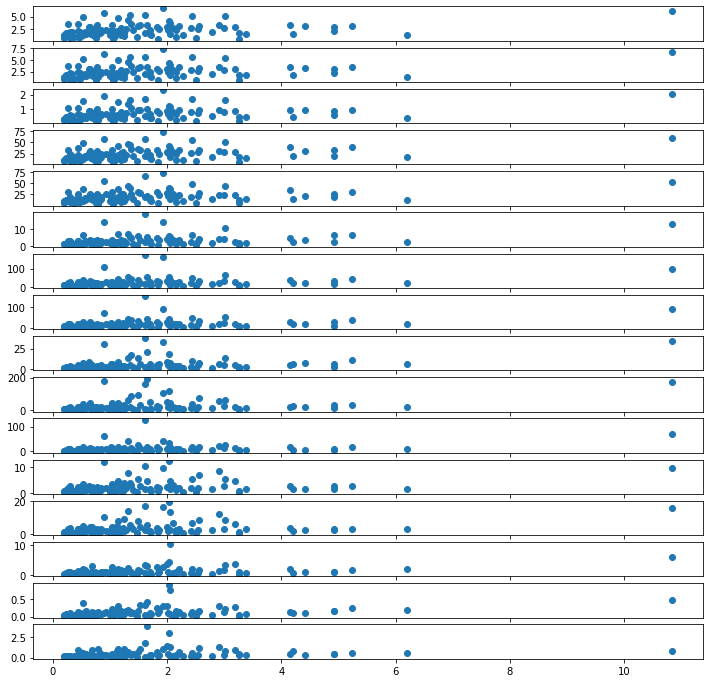

In [3]:
fig, axs = plt.subplots(len(varis), figsize=(12,12))
[axs[i].scatter(mses, v) for i, (k, v) in enumerate(varis.items())]
plt.show()